In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
import os

import tensorly as tl
from cmtf import CMTF
from utils import replace_nan, match_score, normalize_vector
from visualization import plot_match_scores, plot_concentrations_per_mixtures

concentrations = pd.read_table("../Acar_data/concentrations.txt", sep="\s+")
mat = sio.loadmat("../Acar_data/EEM_NMR_LCMS.mat")

# creating output directories if they do not exist
if not os.path.exists("./figures"):
    os.makedirs("./figures")
if not os.path.exists("./output_data"):
    os.makedirs("./output_data")

In [2]:
# plots parameters
parafac_colors = mpl.colormaps['Dark2'].colors[3:]

# Data description

## Mixture concentrations

In [3]:
gt_concentrations = np.zeros_like(concentrations)
for idx in range(concentrations.shape[1]):
    gt_concentrations[:, idx] = normalize_vector(concentrations.iloc[:, idx])

print(concentrations.shape)
print((concentrations != 0).sum(axis=1).describe())

(28, 5)
count    28.000000
mean      3.321429
std       1.278123
min       1.000000
25%       3.000000
50%       4.000000
75%       4.000000
max       5.000000
dtype: float64


## Fluorescence Spectroscopy (Excitation Emission Matrix - EEM)

- 28 mixtures
- emission wavelength (mode 2)
- excitation wavelength (mode 3)

In [4]:
eem = mat["X"][0][0]["data"]
eem = replace_nan(eem, strategy="zero")
print(eem.shape)

(28, 251, 21)


## NMR spectra
- 28 mixtures
- chemical shifts (mode 2)
- gradient levels (mode 3)

In [5]:
nmr = mat["Y"][0][0]["data"]
nmr = replace_nan(nmr, strategy="zero")
print(nmr.shape)

(28, 13324, 8)


## LC-MS

Matrix n_mixtures x n_features

In [6]:
lcms = mat["Z"][0][0]["data"]

print(lcms.shape)

(28, 168)


# Tensor decomposition

## PARAFAC

In [7]:
parafac_performance = []

### NMR spectra only

In [8]:
rank = 5
fac_nmr = tl.decomposition.parafac(nmr, rank=rank, init="svd", normalize_factors=True)

In [9]:
parafac_nmr_u1 = fac_nmr[1][0]
parafac_nmr_u1 = np.abs(parafac_nmr_u1)
x_ticks = np.arange(28)

[0.85999875 0.74747656 0.95586152 0.99001025 0.93741003]


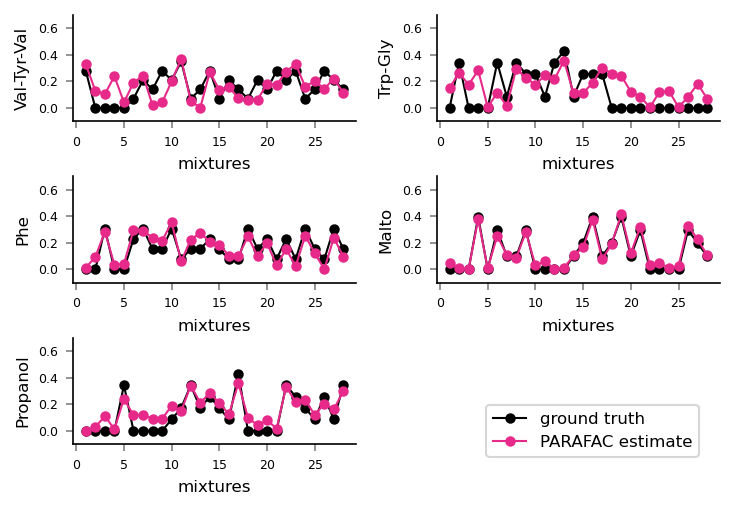

In [10]:
u1_scores_nmr, _, col_inds_nmr = match_score(gt_concentrations, parafac_nmr_u1[:, :5], return_indices=True)
parafac_performance.append(
    pd.DataFrame(u1_scores_nmr).describe().T.set_index(pd.Index(["PARAFAC-NMR"]))
)

print(u1_scores_nmr)

fig = plot_concentrations_per_mixtures(
    gt_concentrations,
    parafac_nmr_u1,
    col_inds_nmr,
    col_labels=concentrations.columns,
    legend_label="PARAFAC estimate",
    color_hat=parafac_colors[0]
)
plt.savefig("figures/parafac_nmr_concentration_per_mixture.pdf", dpi=300)
plt.show()

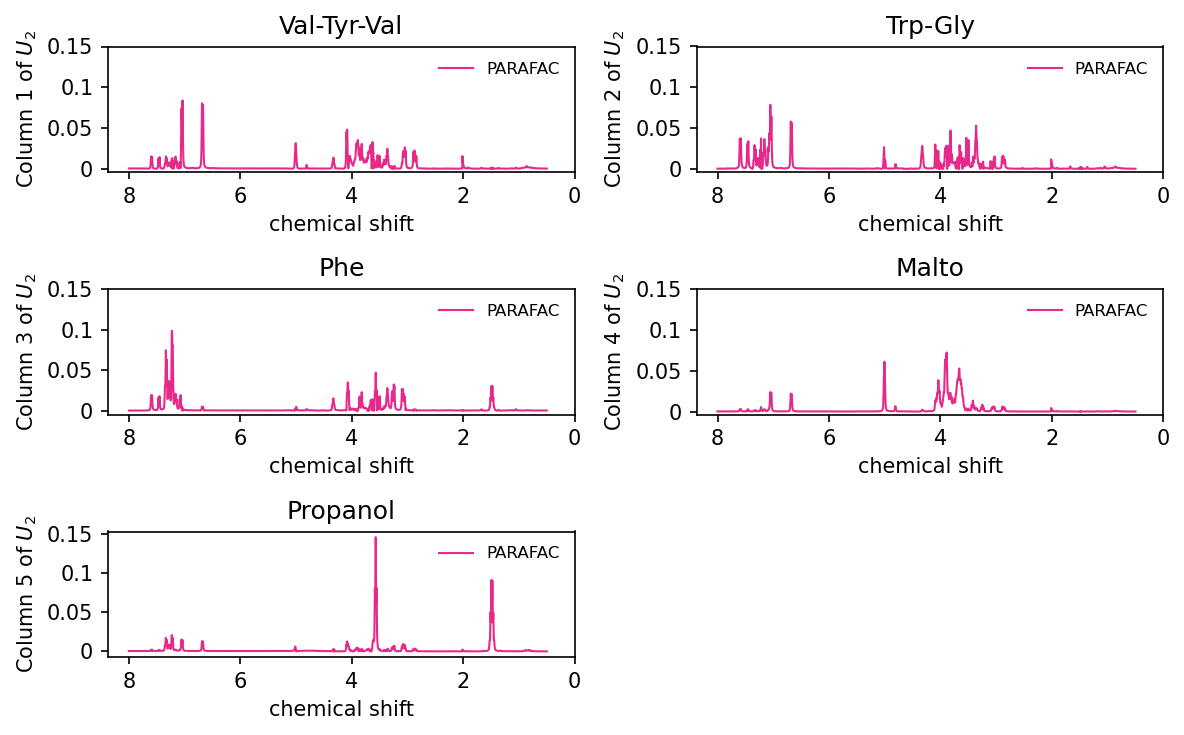

In [11]:
# to further check the reordering of the columns

# this might not be exact (not sure of the exact minimal value of the ppm scale,
# the original paper is not clear on that point)
x_ticks = np.linspace(0.5, 8, 13324)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 5), dpi=150)
axes = axes.flatten()
for i in range(5):
    axes[i].plot(x_ticks, np.abs(fac_nmr[1][1][:, col_inds_nmr[i]]), label="PARAFAC", color=parafac_colors[0], linewidth=1)
    axes[i].set_title(concentrations.columns[i])
    axes[i].invert_xaxis()
    axes[i].legend(frameon=False, fontsize=8)
    axes[i].set_ylabel(f"Column {i + 1} of $U_2$")
    axes[i].set_xlabel("chemical shift")
    axes[i].set_xticks([0, 2, 4, 6, 8], [0, 2, 4, 6, 8], fontsize=10)
    axes[i].set_yticks([0, 0.05, 0.1, 0.15], [0, 0.05, 0.1, 0.15], fontsize=10)
axes[-1].set_axis_off()
fig.tight_layout()
plt.savefig("figures/parafac_nmr_u2_all_columns.pdf", dpi=300)
plt.show()

### EEM tensor only

In [21]:
fac_eem = tl.decomposition.parafac(eem, rank=rank, init="svd", normalize_factors=True)
parafac_eem_u1 = fac_eem[1][0]
parafac_eem_u1 = np.abs(parafac_eem_u1)

[0.9983456  0.99940645 0.99706396 0.5483571  0.52518034]


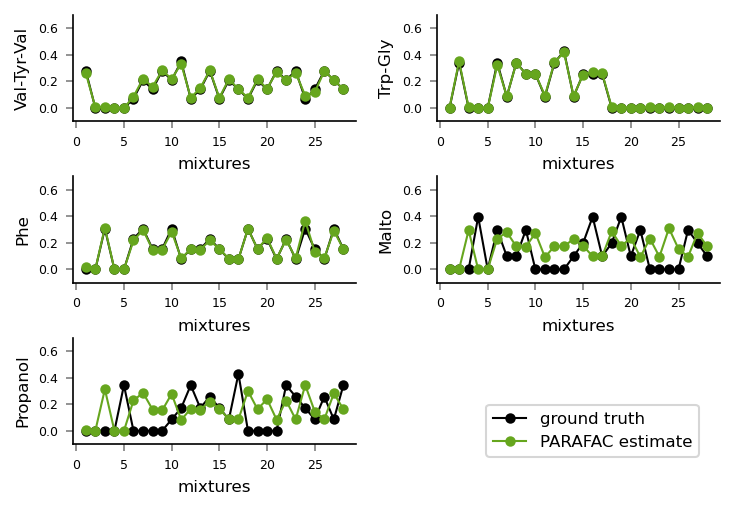

In [22]:
u1_scores_eem, _, col_inds_eem = match_score(gt_concentrations, parafac_eem_u1, return_indices=True)

parafac_performance.append(
    pd.DataFrame(u1_scores_eem).describe().T.set_index(pd.Index(["PARAFAC-EEM"]))
)

print(u1_scores_eem)

fig = plot_concentrations_per_mixtures(
    gt_concentrations,
    parafac_eem_u1,
    col_inds_eem,
    col_labels=concentrations.columns,
    legend_label="PARAFAC estimate",
    color_hat=parafac_colors[1]
)
plt.savefig("figures/parafac_eem_concentration_per_mixture.pdf", dpi=300)
plt.show()

### SVD on the matrix

(28, 168)
[0.96496377 0.73934729 0.82254085 0.65292713 0.47059238]


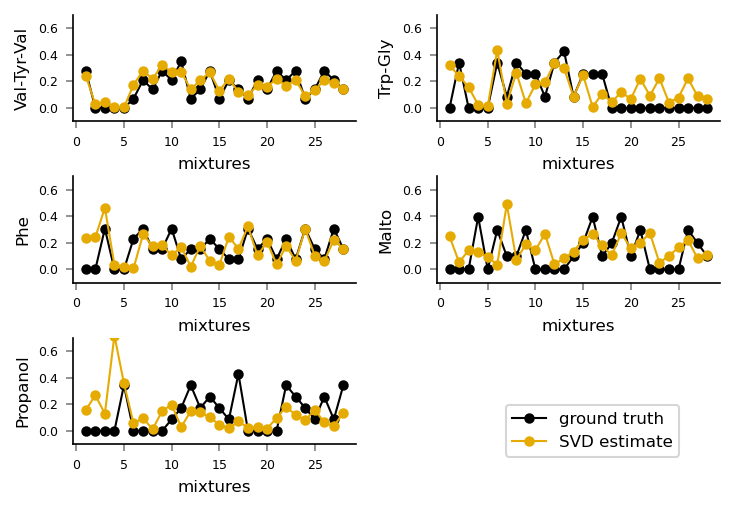

In [23]:
u_lcms, s_lcms, v_lcms = np.linalg.svd(lcms, full_matrices=False)

print(v_lcms.shape)

estimations_concentrations = np.zeros_like(concentrations)
gt_concentrations = np.zeros_like(concentrations)
for idx in range(concentrations.shape[1]):
    estimations_concentrations[:, idx] = np.abs(normalize_vector(u_lcms[:, :5][:, idx]))
    gt_concentrations[:, idx] = normalize_vector(concentrations.iloc[:, idx])

u1_scores_lcms, row_inds, col_inds_lcms = match_score(gt_concentrations, estimations_concentrations,
                                                      return_indices=True)
print(u1_scores_lcms)
parafac_performance.append(
    pd.DataFrame(u1_scores_lcms).describe().T.set_index(pd.Index(["SVD-LCMS"]))
)

fig = plot_concentrations_per_mixtures(
    gt_concentrations,
    estimations_concentrations,
    col_inds_lcms,
    col_labels=concentrations.columns,
    legend_label="SVD estimate",
    color_hat=parafac_colors[2]
)
plt.savefig("figures/svd_lcms_concentration_per_mixture.pdf", dpi=300)
plt.show()

## Plotting the match scores for the three methods

In [24]:
# average performance over the 5 components
df_parafac_performance = pd.concat(parafac_performance)
df_parafac_performance.style.format(precision=2)

,count,mean,std,min,25%,50%,75%,max
PARAFAC-NMR,5.00,0.90,0.10,0.75,0.86,0.94,0.96,0.99
PARAFAC-EEM,5.00,0.81,0.25,0.53,0.55,1.00,1.00,1.00
SVD-LCMS,5.00,0.73,0.19,0.47,0.65,0.74,0.82,0.96
PARAFAC-EEM,5.00,0.81,0.25,0.53,0.55,1.00,1.00,1.00
SVD-LCMS,5.00,0.73,0.19,0.47,0.65,0.74,0.82,0.96


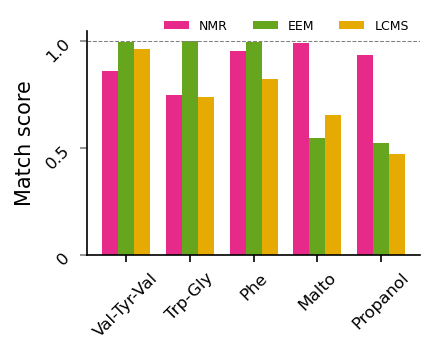

In [31]:
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=150)
plot_match_scores(
    [u1_scores_nmr, u1_scores_eem, u1_scores_lcms],
    x_ticks=np.arange(5),
    x_tick_labels=concentrations.columns,
    show=False,
    labels=["NMR", "EEM", "LCMS"],
    colors=parafac_colors,
    ax=ax
)
ax.tick_params(labelrotation=45)
fig.tight_layout()
plt.savefig("figures/one_way_data_decomposition_comparison.pdf", dpi=300)
plt.show()

## Non-negative PARAFAC

In [17]:
rank = 5
nn_fac_nmr = tl.decomposition.non_negative_parafac(nmr, rank=rank, init="svd", normalize_factors=True)
nn_parafac_nmr_u1 = nn_fac_nmr[1][0]

,count,mean,std,min,25%,50%,75%,max
NMR,5.00,0.99,0.01,0.98,0.99,1.00,1.00,1.00


[0.85999875 0.74747656 0.95586152 0.99001025 0.93741003]


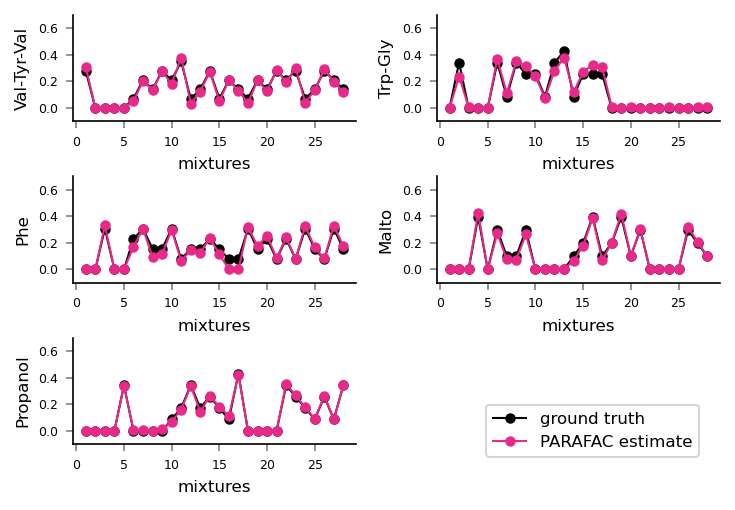

<Figure size 640x480 with 0 Axes>

In [18]:
nn_u1_scores_nmr, _, col_inds_nn_nmr = match_score(gt_concentrations, nn_parafac_nmr_u1[:, :5], return_indices=True)
display(pd.DataFrame(nn_u1_scores_nmr).describe().T.set_index(pd.Index(["NMR"])).style.format(precision=2))

print(u1_scores_nmr)

fig = plot_concentrations_per_mixtures(
    gt_concentrations,
    nn_parafac_nmr_u1,
    col_inds_nn_nmr,
    col_labels=concentrations.columns,
    legend_label="PARAFAC estimate",
    color_hat=parafac_colors[0]
)
plt.show()
plt.savefig("figures/nn_parafac_nmr_concentration_per_mixture.pdf", dpi=300)

In [19]:
nn_parafac_nmr_u2 = nn_fac_nmr[1][1]
print(nn_parafac_nmr_u2.shape)

(13324, 5)


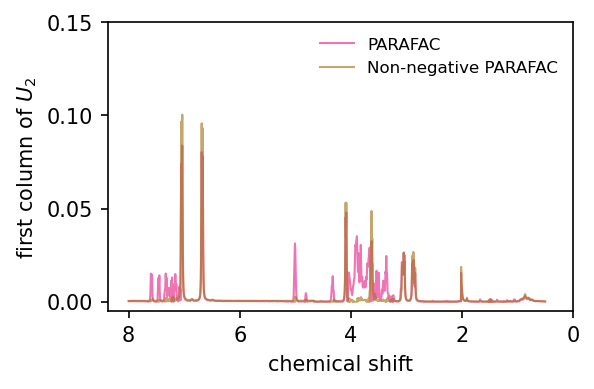

In [20]:
plt.figure(figsize=(4, 2.5), dpi=150)
x_ticks = np.linspace(0.5, 8, nn_parafac_nmr_u2[:, col_inds_nn_nmr[0]].shape[0])
plt.plot(x_ticks, np.abs(fac_nmr[1][1][:, col_inds_nmr[0]]), label="PARAFAC", color=parafac_colors[0], linewidth=1, alpha=.65)
plt.plot(x_ticks, nn_parafac_nmr_u2[:, col_inds_nn_nmr[0]], label="Non-negative PARAFAC", color=parafac_colors[3], linewidth=1, alpha=.65)
plt.gca().invert_xaxis()
plt.xticks([0, 2, 4, 6, 8], fontsize=10)
plt.yticks([0, 0.05, 0.1, 0.15], fontsize=10)
plt.legend(frameon=False, fontsize=8)
plt.ylabel("first column of $U_2$")
plt.xlabel("chemical shift")
plt.savefig("figures/nn_parafac_vs_parafac_nmr_first_col_u2.pdf", dpi=300)
plt.show()